In [1]:
# Import system modules
import obspy
from os.path import getsize, join
from shutil import copyfile
import matplotlib.pyplot as plt
# Import numpy
import warnings
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
# Local imports
from seisflows.tools.tools import iterable
import matplotlib.colors as colors

In [2]:
def read_slice(path, parameters, iproc):
    """ Reads SPECFEM model slice(s)
        Such as, for example : proc000005_vp.bin
        In that specific case it would be : read_slice(path, 'vp', 5)
    """
    vals = []
    for key in parameters:
        filename = '%s/proc%06d_%s.bin' % (path, iproc, key)
        vals += [_read(filename)]
    return vals

def _read(filename):
    """ Reads Fortran style binary data into numpy array
    """
    nbytes = getsize(filename)
    with open(filename, 'rb') as file:
        # read size of record
        file.seek(0)
        n = np.fromfile(file, dtype='int32', count=1)[0]
        if n == nbytes-8:
            file.seek(4)
            data = np.fromfile(file, dtype='float32')
            return data[:-1]
        else:
            file.seek(0)
            data = np.fromfile(file, dtype='float32')
            return data

In [3]:
def readStations(path):
    """ Read specfem2d STATIONS file
    """
    with warnings.catch_warnings():  # Suppress warning about single precision
        warnings.simplefilter("ignore")
        stats = np.genfromtxt(path, usecols=(0, 2, 3), dtype=None)
    temp = [list(u) for u in stats]
    temp = map(list, zip(*temp))
    return temp[:][0], np.array(temp[:][1]), np.array(temp[:][2])

In [4]:
def readSources(path, NSRC):
    """Read specfem2d SOURCE file with standard 14 parameter
    """
    data = np.genfromtxt('./SOURCE_000000')
    temp = [list(u) for u in [data[:,2]]]
    temp = map(list, zip(*temp))
    xs = [temp[i * 14 + 1] for i in range(NSRC)]
    zs = [temp[i * 14 + 2] for i in range(NSRC)]
    return xs, zs

In [5]:
def read_model(PATH):
    pars = ["rho","vp","vs"]
    NPROC = 1
#     PATH = './model_true/'

    DATA = {}
    for PROC in range(NPROC):
        for COORD in ['x', 'z']:
            if PROC ==0:
                DATA[COORD] = read_slice(path = PATH, parameters = [COORD], iproc = PROC)
            else:
                DATA[COORD][0] = np.append(DATA[COORD][0], read_slice(path = PATH, parameters = [COORD], iproc = PROC))
        for PAR in pars:
            if PROC == 0:
                DATA[PAR] = read_slice(path = PATH, parameters = [PAR], iproc = PROC)
            else:
                DATA[PAR][0] = np.append(DATA[PAR][0], read_slice(path = PATH, parameters = [PAR], iproc = PROC))
    return DATA

In [7]:
interface = np.loadtxt('./interface.dat')
init_model = read_model('../model_gen/model_initial/')
true_model = read_model('../model_gen/model_checkerboard/')
inv_model = read_model('./model_0003/')

bounds = np.linspace(1900, 3200, 125)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

bounds = np.linspace(3300, 5500, 125)
normp = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

bounds = np.linspace(-400, +400, 125)
normdp = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

bounds = np.linspace(-240, +240, 125)
normds = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

/opt/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


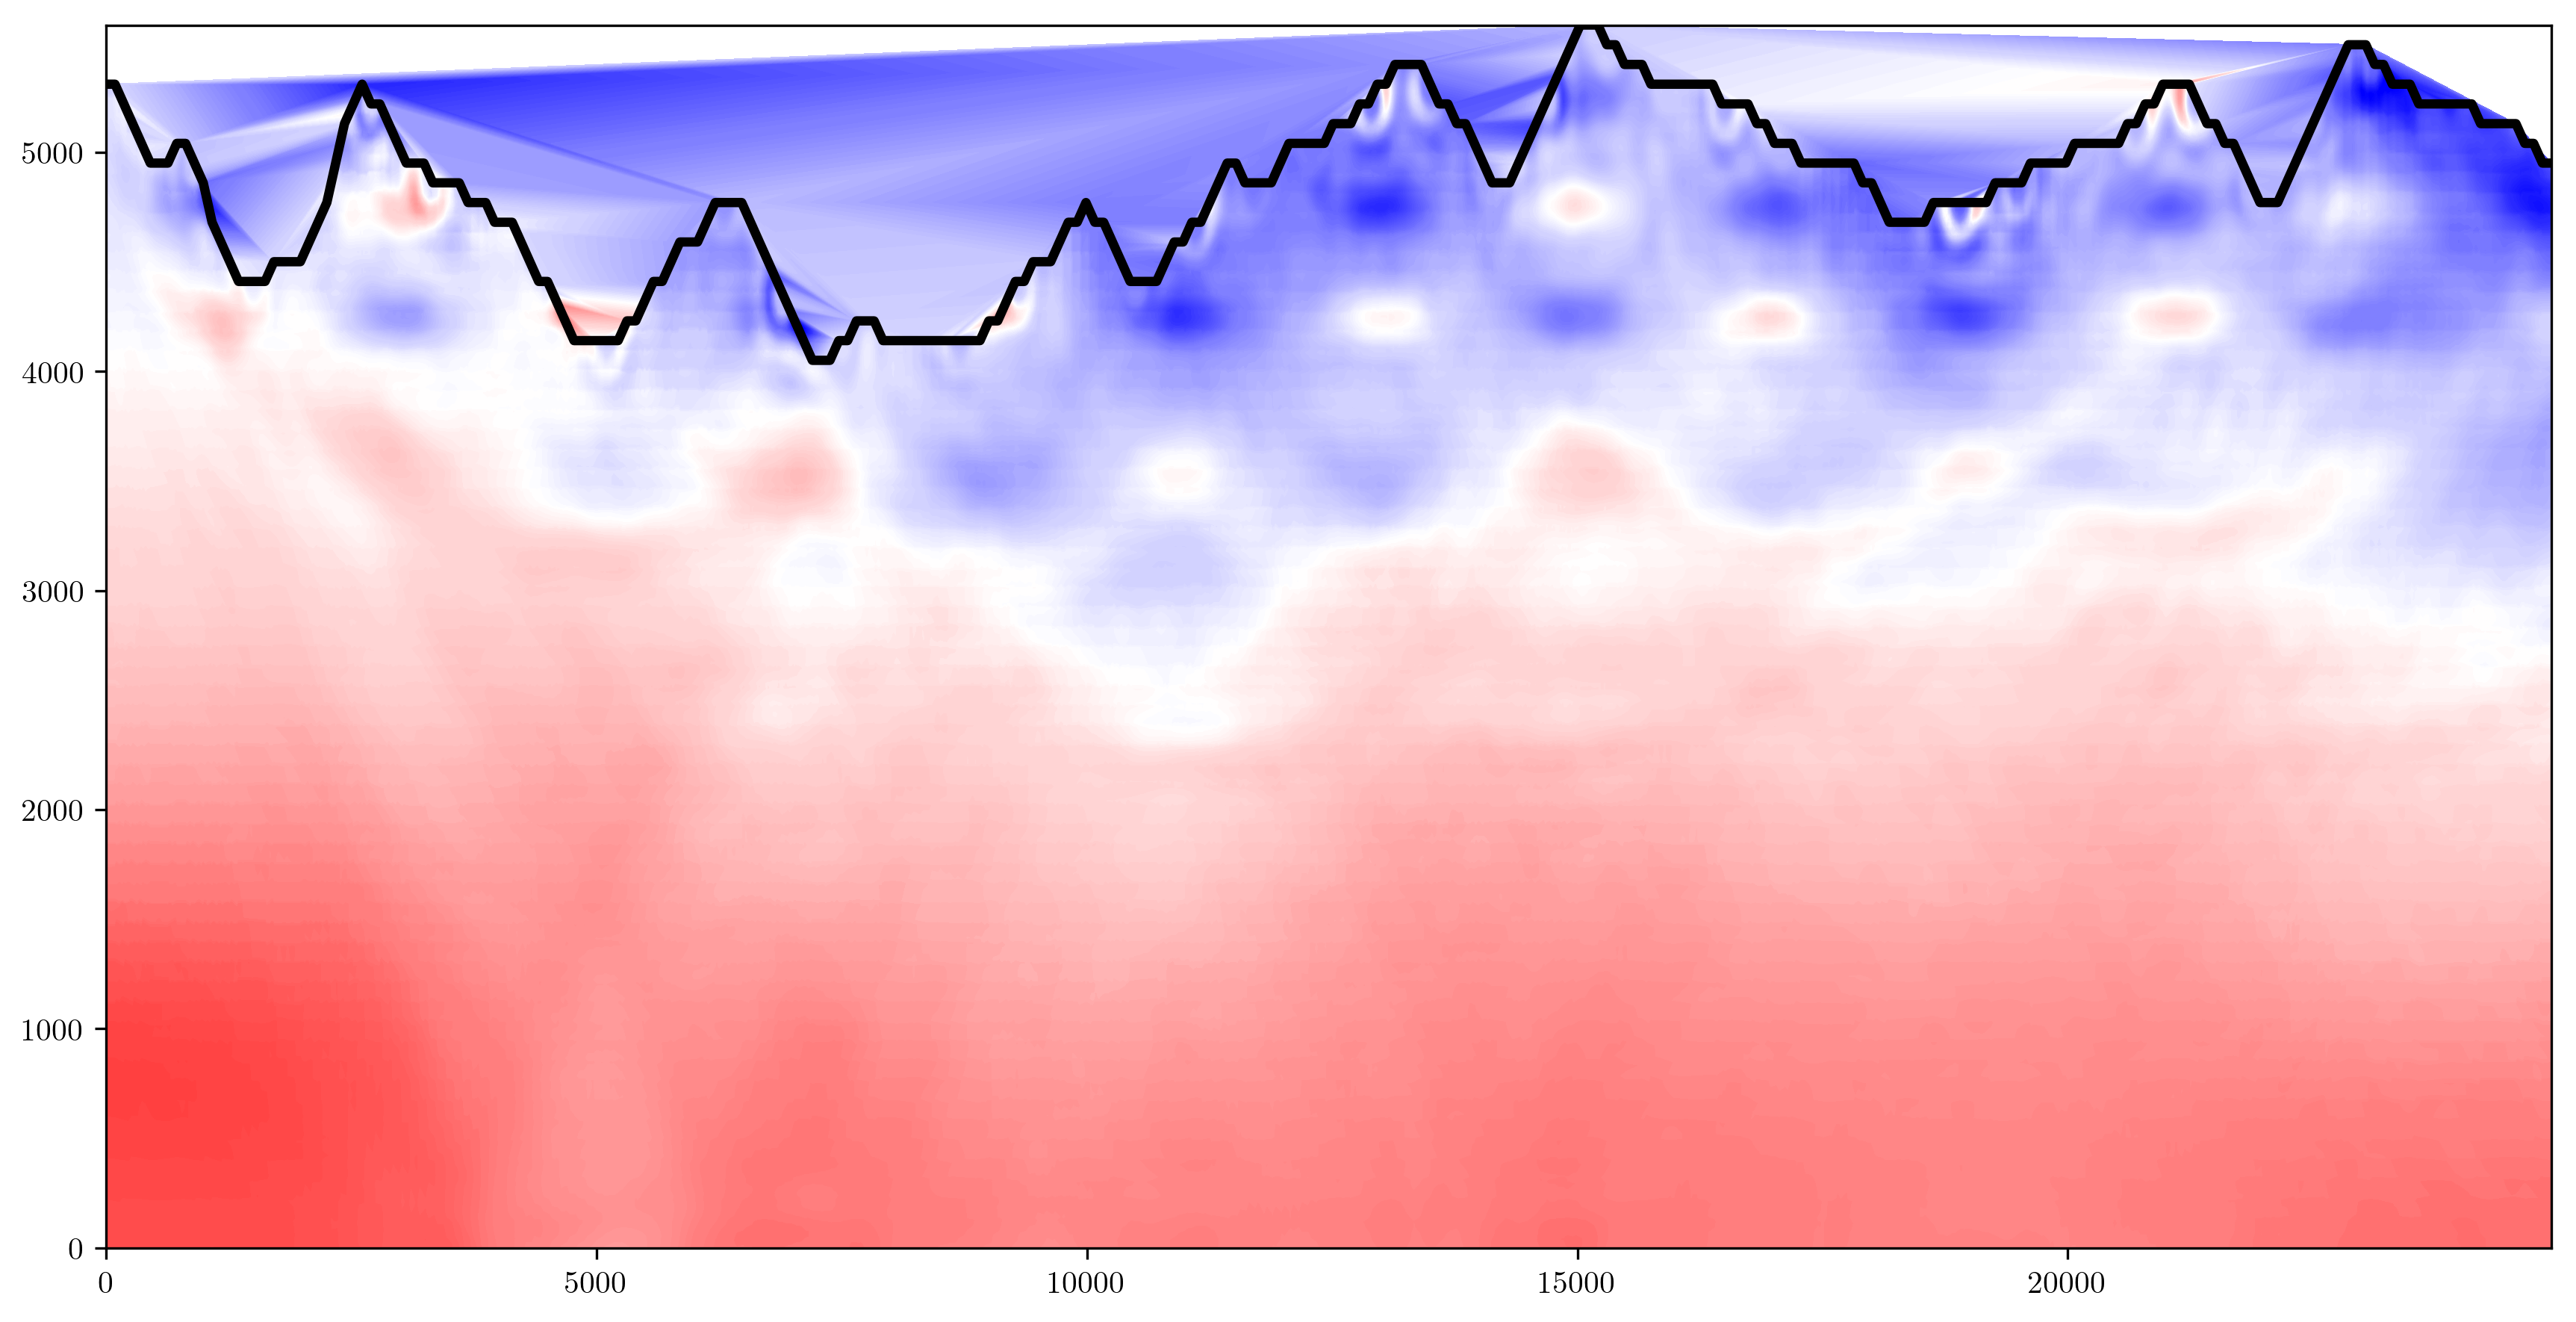

In [8]:
r = (max(true_model['x'][0]) - min(true_model['x'][0]))/(max(true_model['z'][0]) - min(true_model['z'][0]))
rx = r/np.sqrt(1 + r**2)
ry = 1/np.sqrt(1 + r**2)
plt.figure(figsize=(12, 6), dpi = 300)
plt.tricontourf(true_model['x'][0], true_model['z'][0], inv_model['vs'][0], 125, norm = norms)
plt.axes().set_aspect(rx/(2*ry))
# cbar = plt.colorbar(orientation='vertical')
# cbar.set_label(r'$V_s [m/s]$', fontsize=20, labelpad=10)
plt.set_cmap('bwr')
# plt.title(r'$V_s$', fontsize = 20)
# plt.xlabel(r'$X/m$', fontsize = 20)
# plt.ylabel(r'$Z/m$', fontsize = 20)
plt.plot(interface[:,0],interface[:,1],'-', c = 'k', LineWidth = 3)
plt.tight_layout()
plt.savefig('./vs50.png')

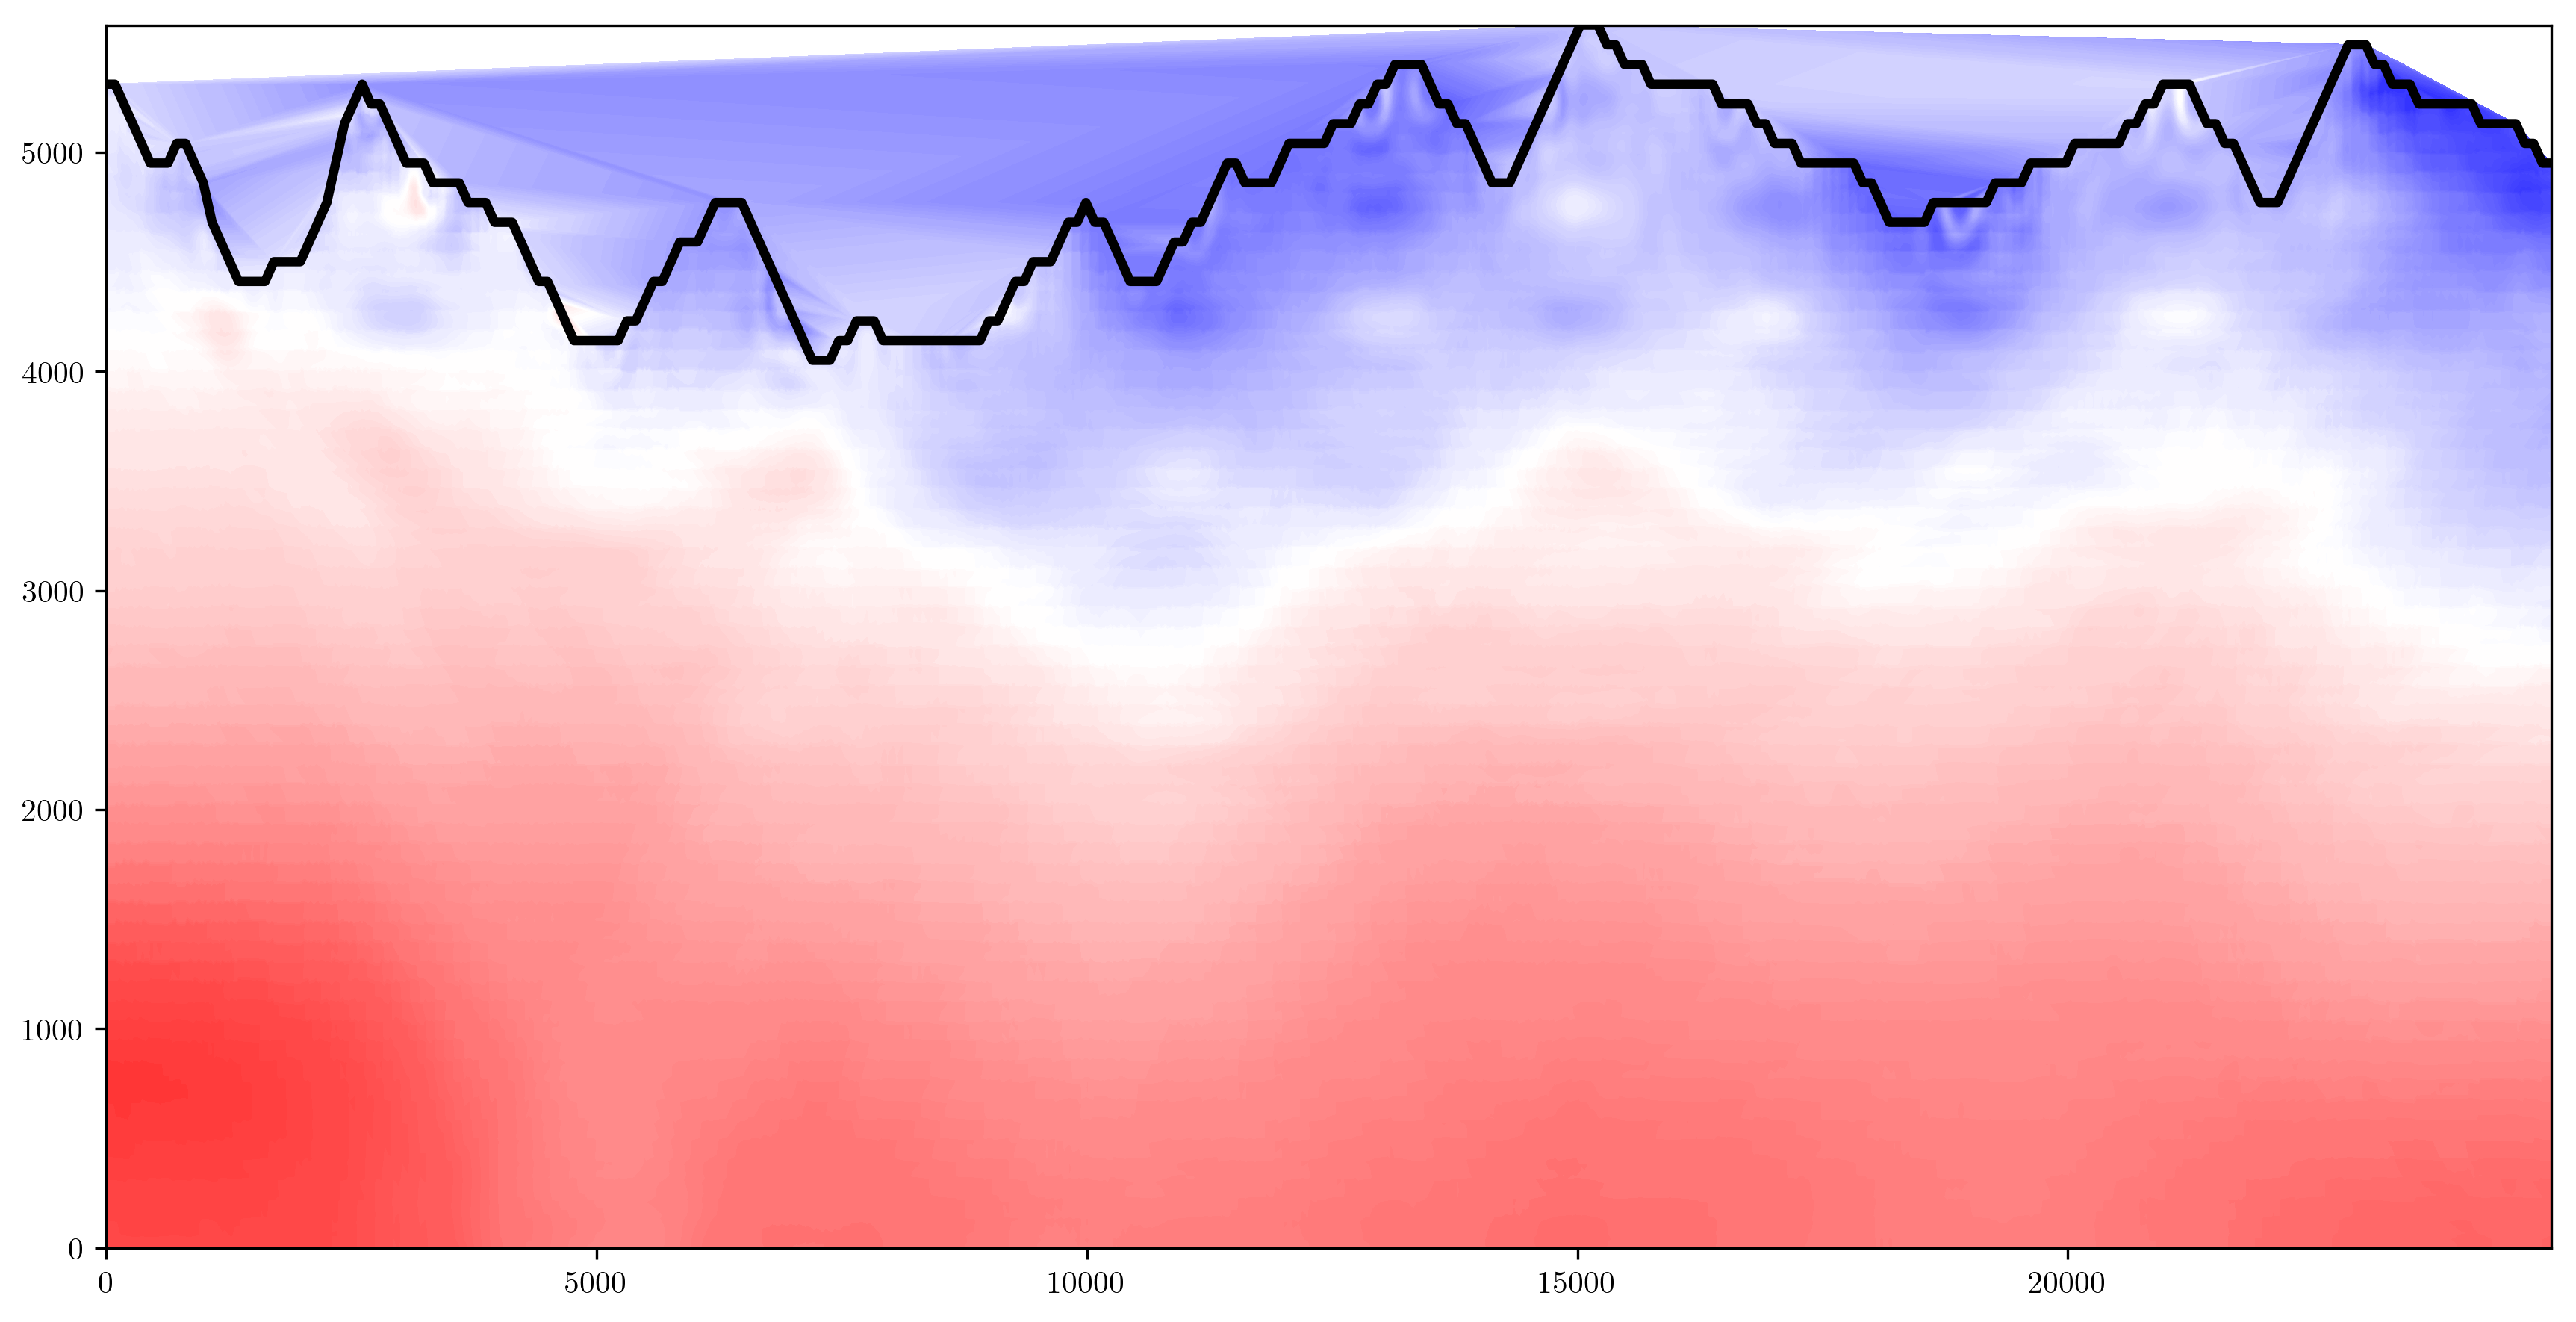

In [9]:
r = (max(true_model['x'][0]) - min(true_model['x'][0]))/(max(true_model['z'][0]) - min(true_model['z'][0]))
rx = r/np.sqrt(1 + r**2)
ry = 1/np.sqrt(1 + r**2)
plt.figure(figsize=(12, 6), dpi = 300)
plt.tricontourf(true_model['x'][0], true_model['z'][0], inv_model['vp'][0], 125, norm = normp)
plt.axes().set_aspect(rx/(2*ry))
# cbar = plt.colorbar(orientation='vertical')
# cbar.set_label(r'$V_p [m/s]$', fontsize=20, labelpad=10)
plt.set_cmap('bwr')
# plt.title(r'$V_p$', fontsize = 20)
# plt.xlabel(r'$X/m$', fontsize = 20)
# plt.ylabel(r'$Z/m$', fontsize = 20)
plt.plot(interface[:,0],interface[:,1],'-', c = 'k', LineWidth = 3)
plt.tight_layout()
plt.savefig('./vp50.png')

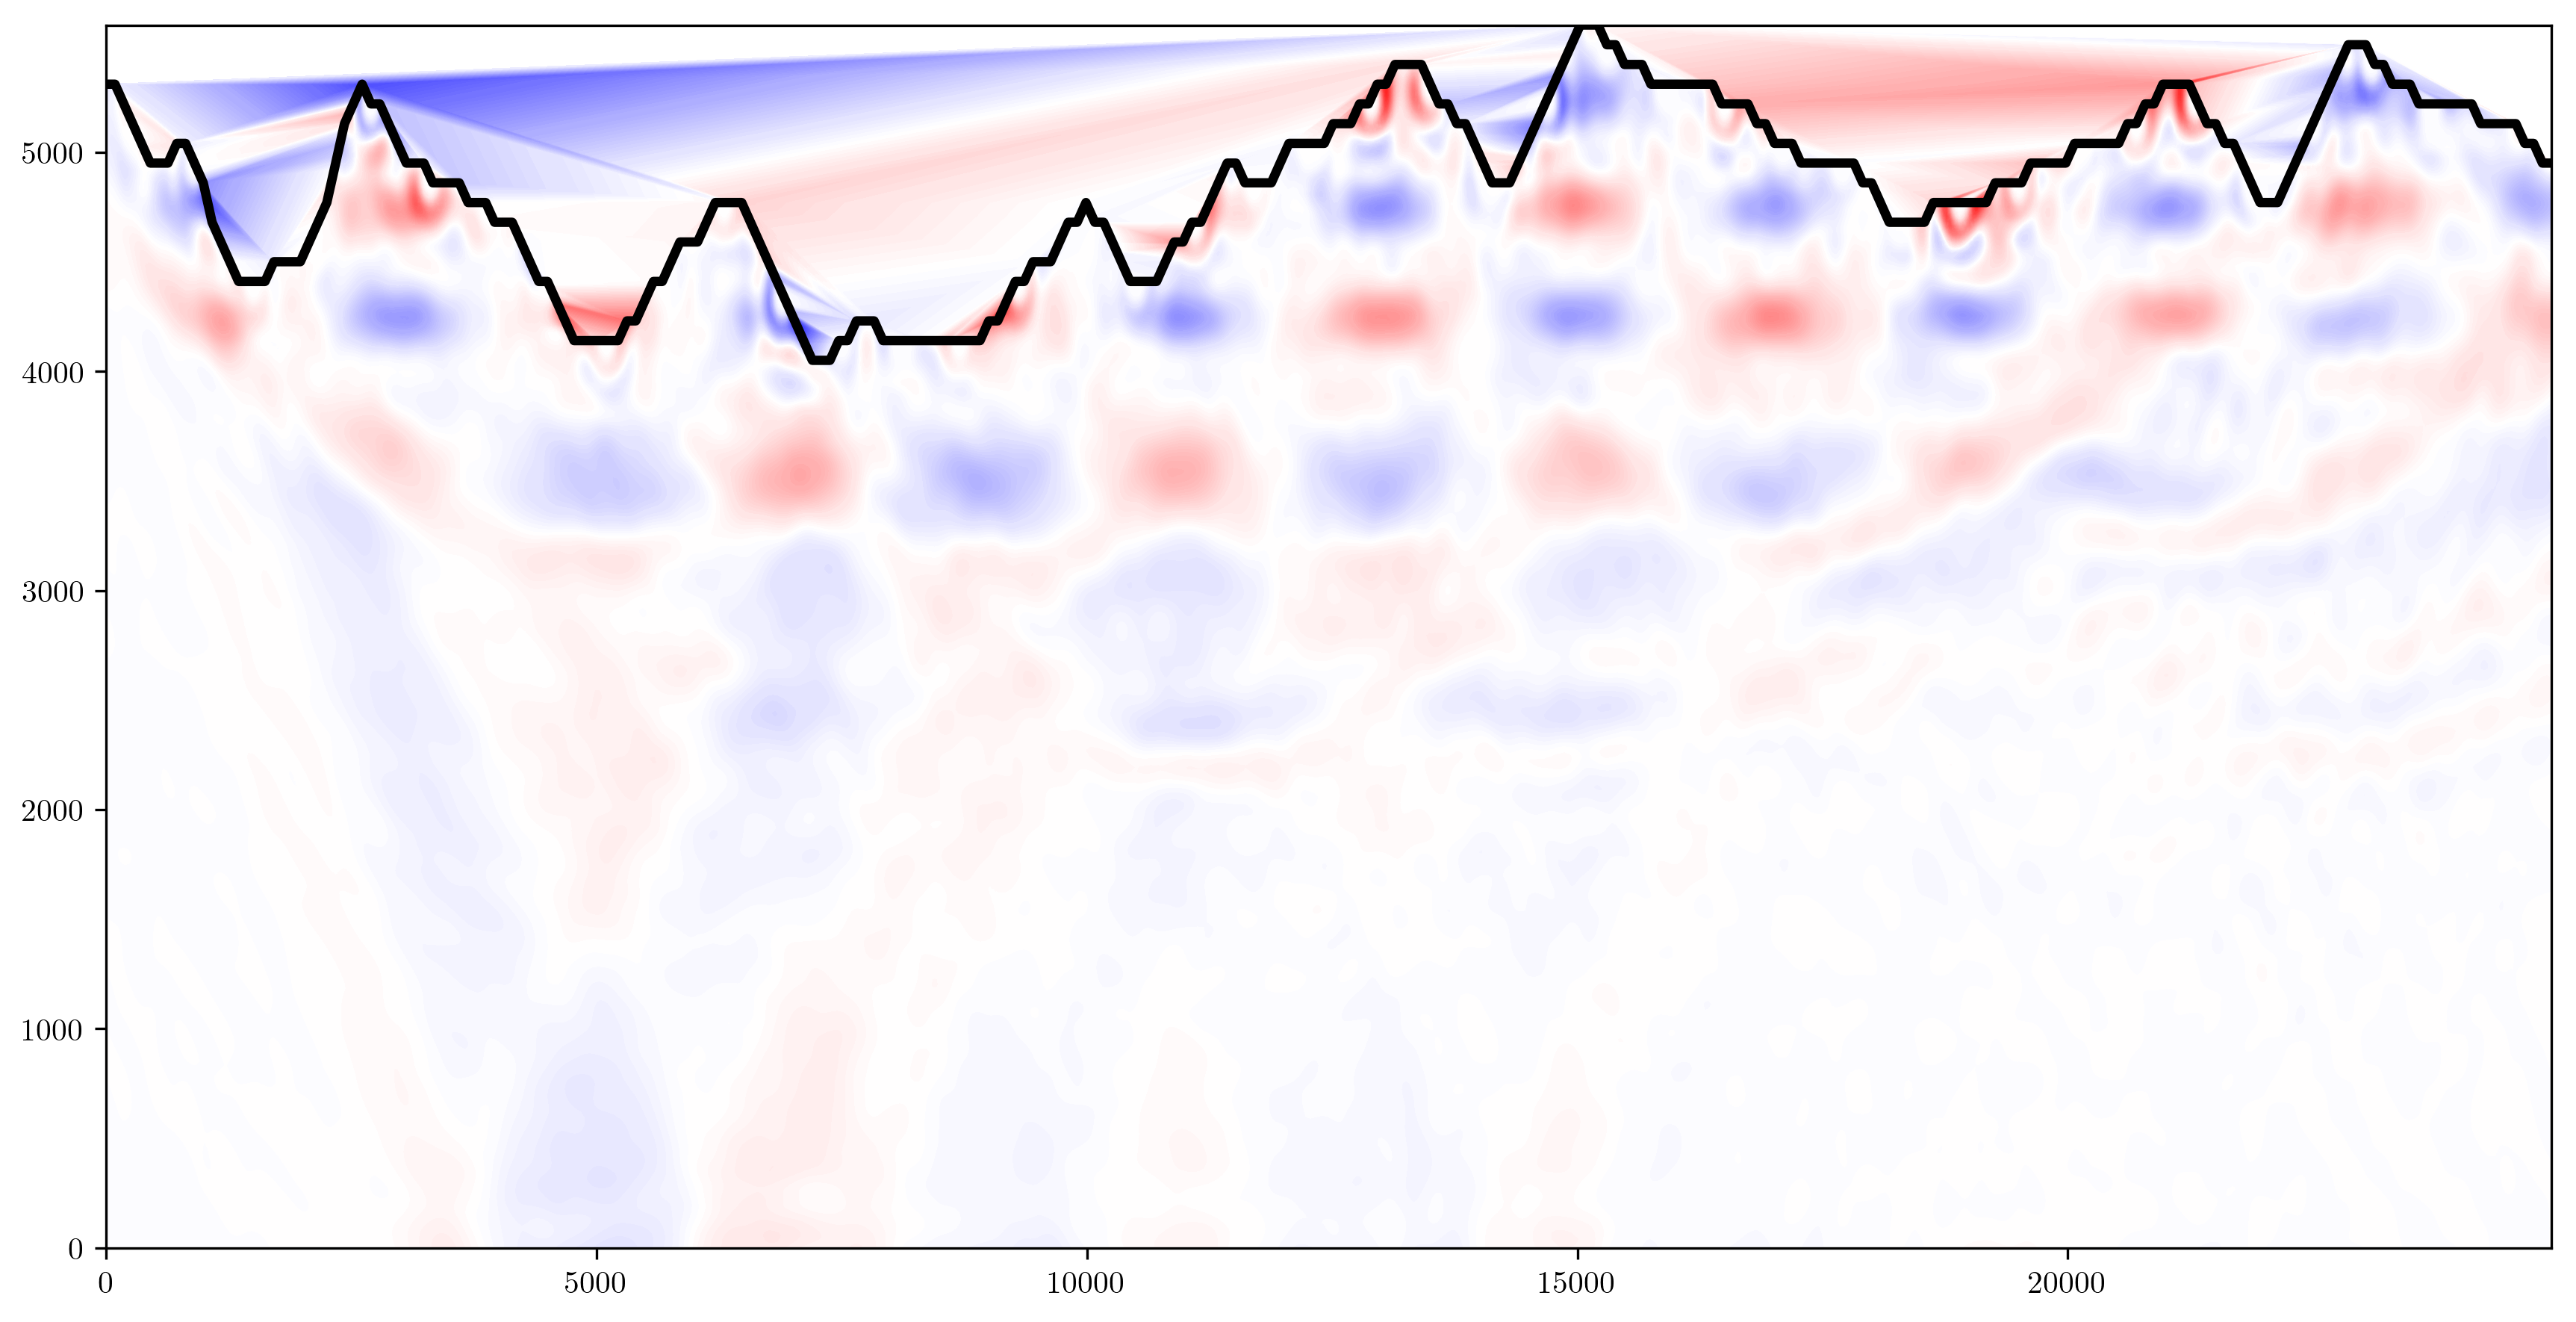

In [10]:
r = (max(true_model['x'][0]) - min(true_model['x'][0]))/(max(true_model['z'][0]) - min(true_model['z'][0]))
rx = r/np.sqrt(1 + r**2)
ry = 1/np.sqrt(1 + r**2)
plt.figure(figsize=(12, 6), dpi = 300)
plt.tricontourf(true_model['x'][0], true_model['z'][0], inv_model['vp'][0]-init_model['vp'][0], 125, norm = normdp)
plt.axes().set_aspect(rx/(2*ry))
# cbar = plt.colorbar(orientation='vertical')
# cbar.set_label(r'$\Delta V_p [m/s]$', fontsize=20, labelpad=10)
plt.set_cmap('bwr')
# plt.title(r'$\Delta V_p$', fontsize = 20)
# plt.xlabel(r'$X/m$', fontsize = 20)
# plt.ylabel(r'$Z/m$', fontsize = 20)
plt.plot(interface[:,0],interface[:,1],'-', c = 'k', LineWidth = 3)
plt.tight_layout()
plt.savefig('./dvp50.png')

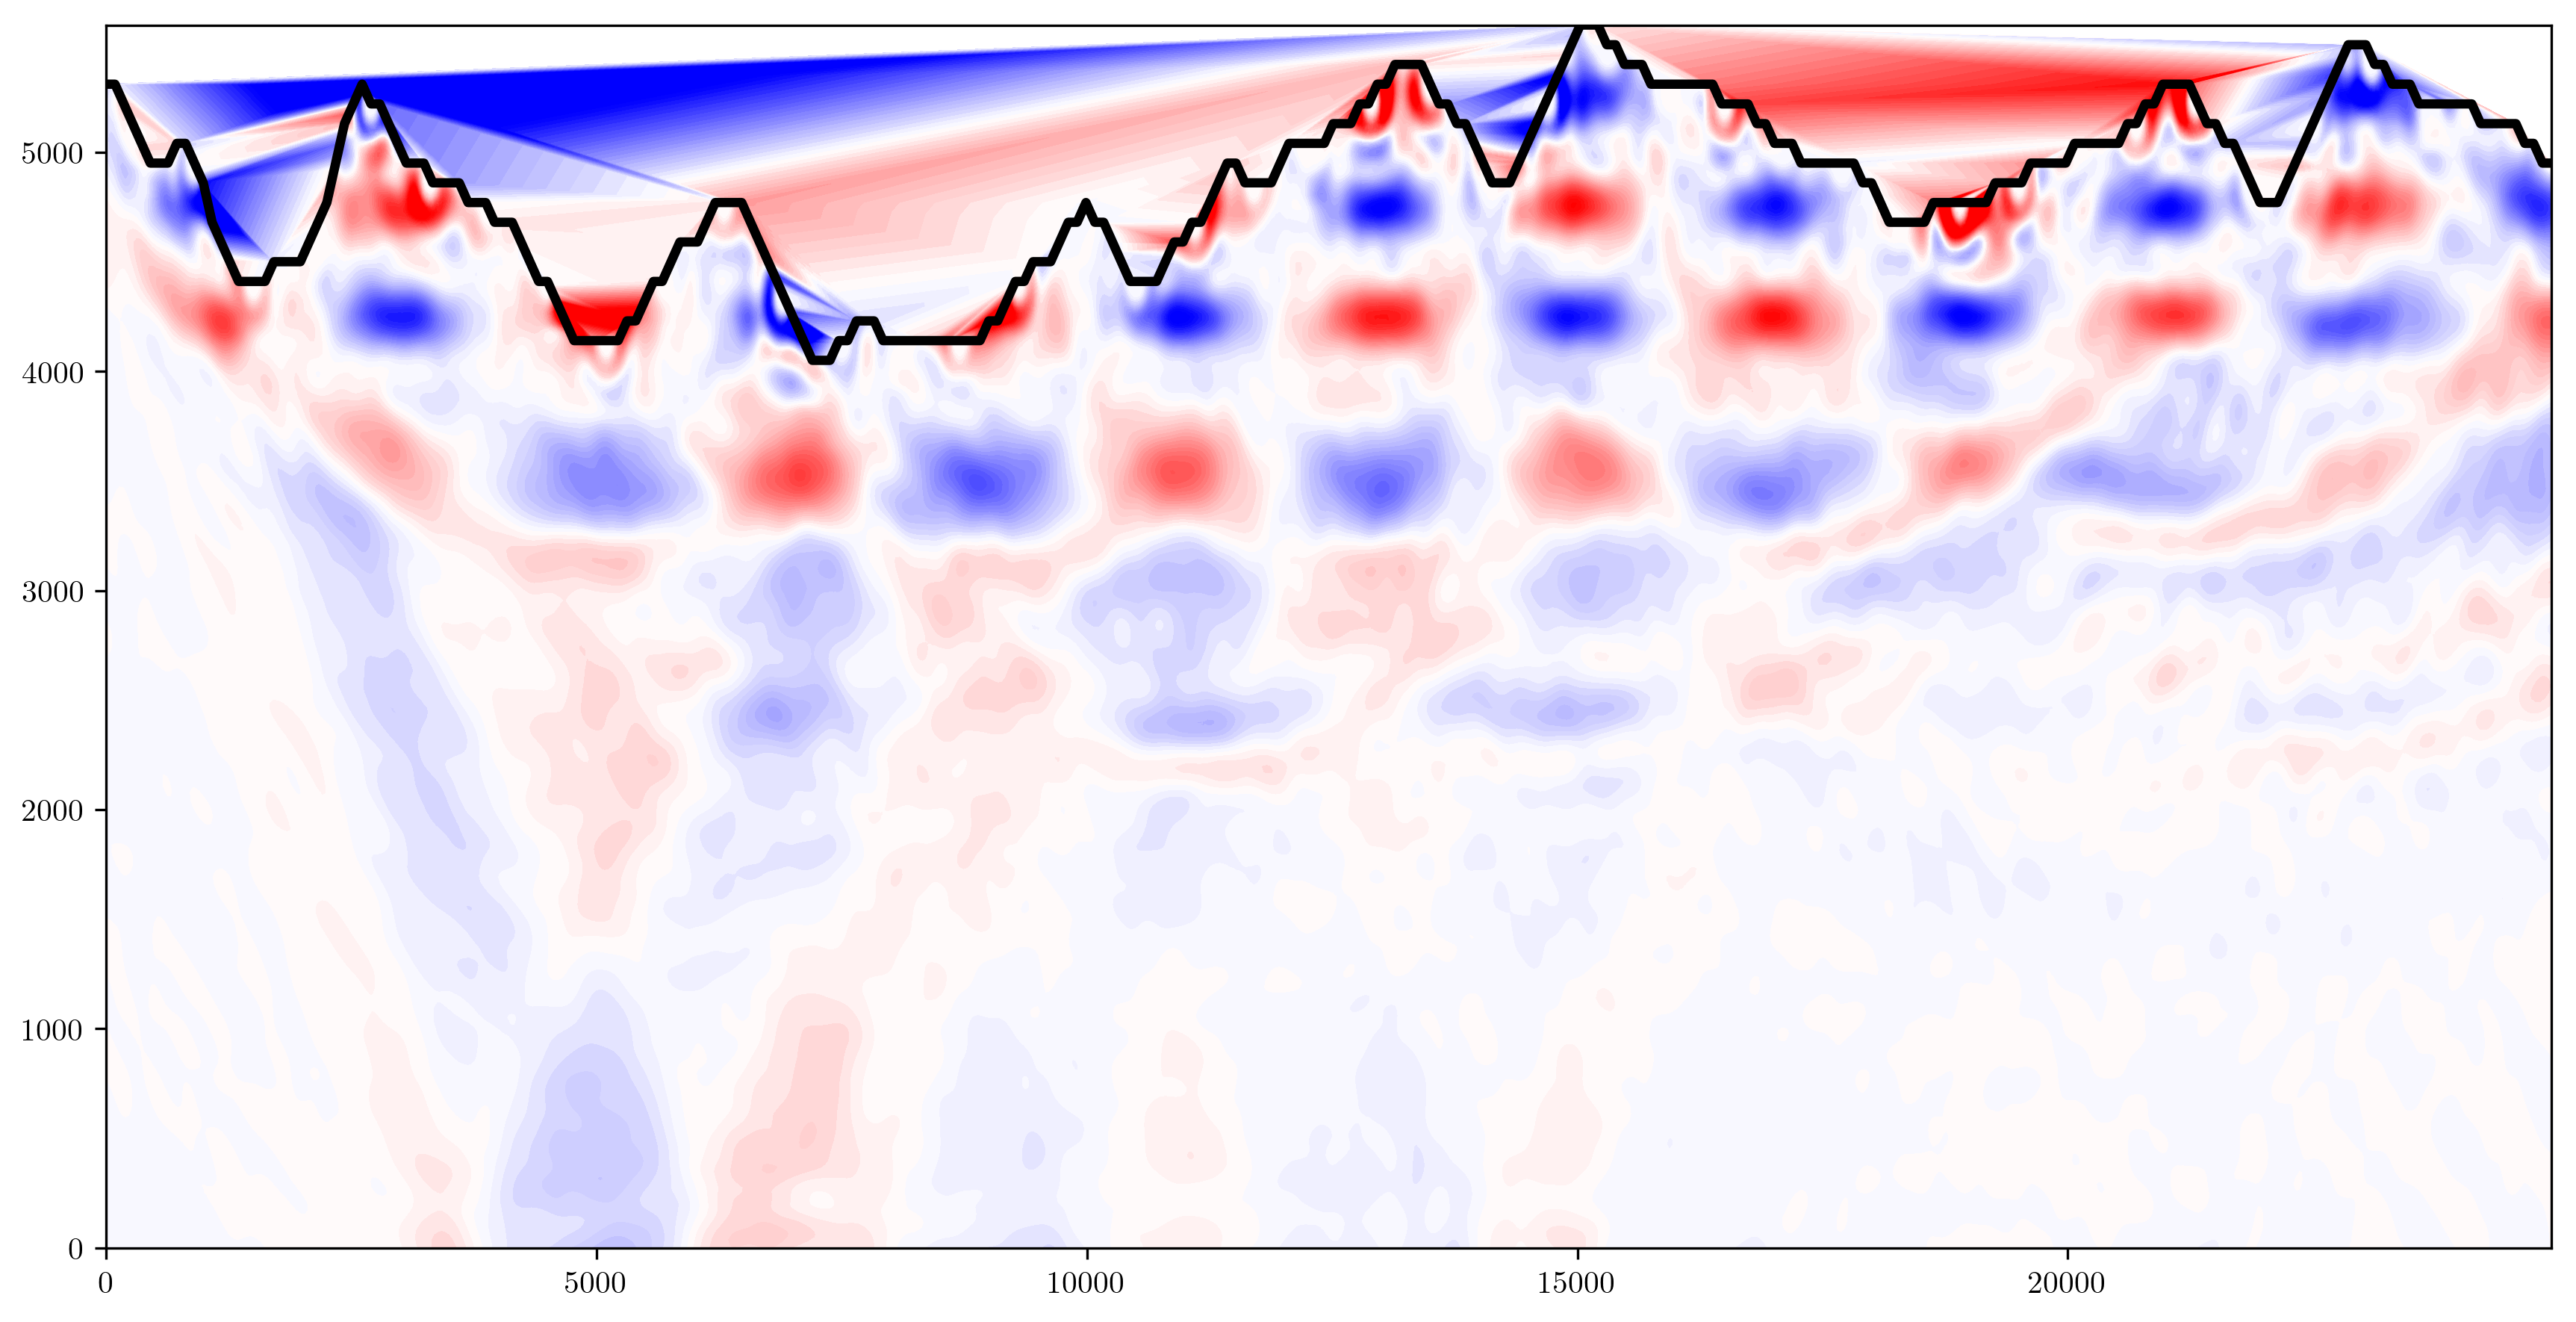

In [11]:
r = (max(true_model['x'][0]) - min(true_model['x'][0]))/(max(true_model['z'][0]) - min(true_model['z'][0]))
rx = r/np.sqrt(1 + r**2)
ry = 1/np.sqrt(1 + r**2)
plt.figure(figsize=(12, 6), dpi = 300)
plt.tricontourf(true_model['x'][0], true_model['z'][0], inv_model['vs'][0]-init_model['vs'][0], 125, norm = normds)
plt.axes().set_aspect(rx/(2*ry))
# cbar = plt.colorbar(orientation='vertical')
# cbar.set_label(r'$\Delta V_s [m/s]$', fontsize=20, labelpad=10)
plt.set_cmap('bwr')
# plt.title(r'$\Delta V_p$', fontsize = 20)
# plt.xlabel(r'$X/m$', fontsize = 20)
# plt.ylabel(r'$Z/m$', fontsize = 20)
plt.plot(interface[:,0],interface[:,1],'-', c = 'k', LineWidth = 3)
plt.tight_layout()
plt.savefig('./dvs50.png')

In [12]:
obs = obspy.read('./traces/obs/Uz_file_single.su')
syn = obspy.read('./traces/syn/Uz_file_single.su')

In [34]:
adj = obspy.read('./traces/adj/Uz_file_single.su.adj')

In [16]:

i = 1
for trace in obs:
    trace.stats.distance = i * 60-obs[NTR].stats.su.trace_header.source_coordinate_x
    i += 1
i = 1
for trace in syn:
    trace.stats.distance = i * 60-obs[NTR].stats.su.trace_header.source_coordinate_x
    i += 1
# i = 1
# for trace in adj:
#     trace.stats.distance = i * 60-adj[NTR].stats.su.trace_header.source_coordinate_x
#     i += 1

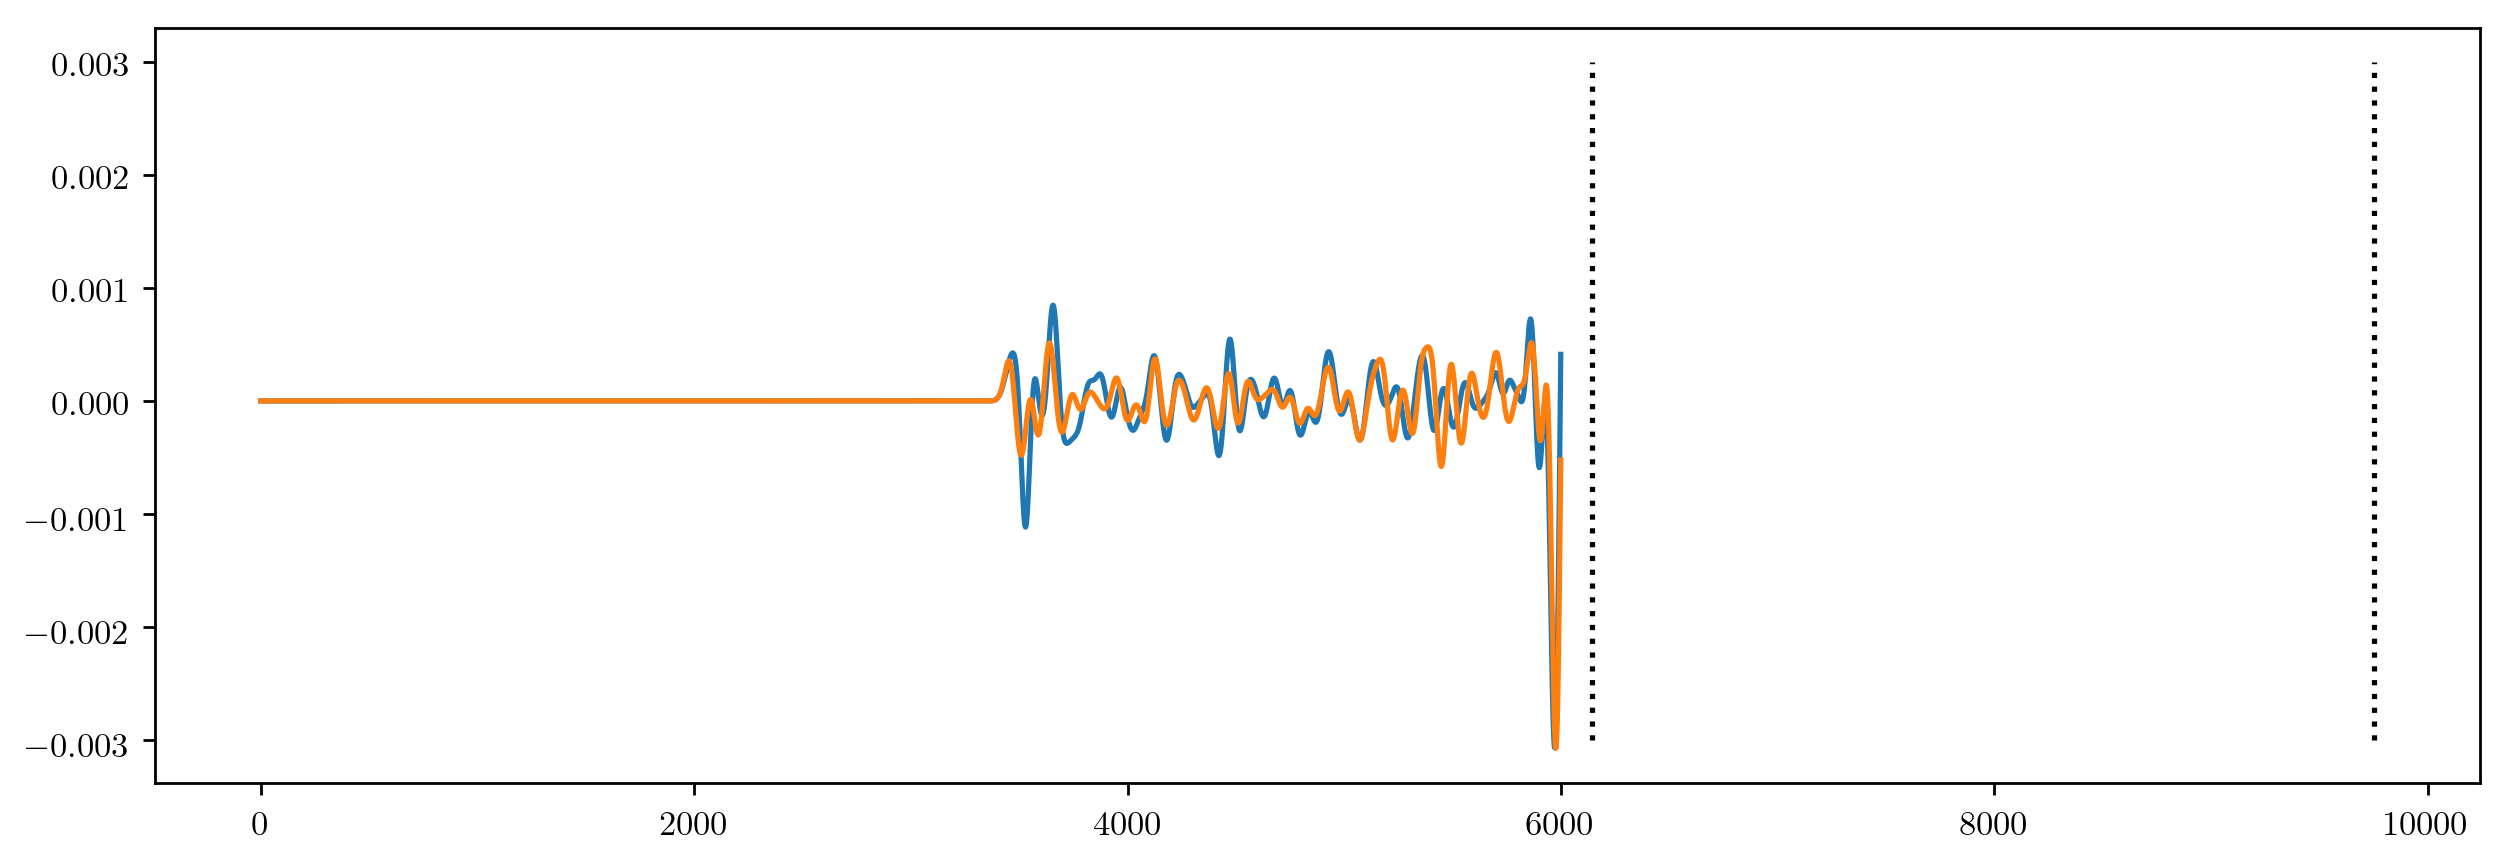

In [21]:
NTR = 20

t1 = 0.01 + 0.00044444*abs(obs[NTR].stats.distance)
nt1 = np.floor(t1/obs[NTR].stats.delta)
t2 = 0.01 + 0.00070588*abs(obs[NTR].stats.distance)
nt2 = np.floor(t2/obs[NTR].stats.delta)

plt.figure(figsize=(12,4), dpi = 250)
plt.plot(obs[NTR].data)
plt.plot(syn[NTR].data)
# plt.ylim([-0.020, 0.020])
plt.plot(nt1*np.ones([10,1]), np.linspace(-0.003, 0.003, 10), ':', c = 'k')
plt.plot(nt2*np.ones([10,1]), np.linspace(-0.003, 0.003, 10), ':', c = 'k')

# ax = plt.gca().twinx()
# ax.plot(adj[NTR].data)


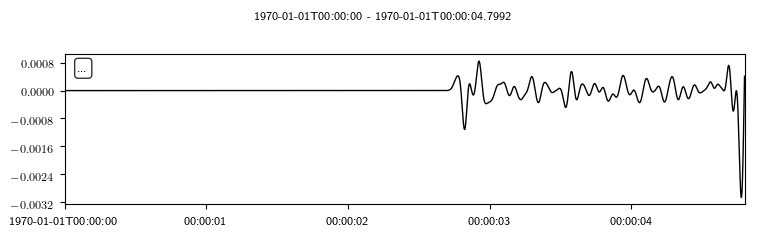

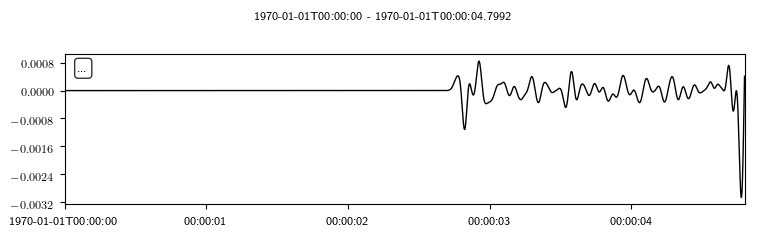

In [23]:
obs[NTR].plot()

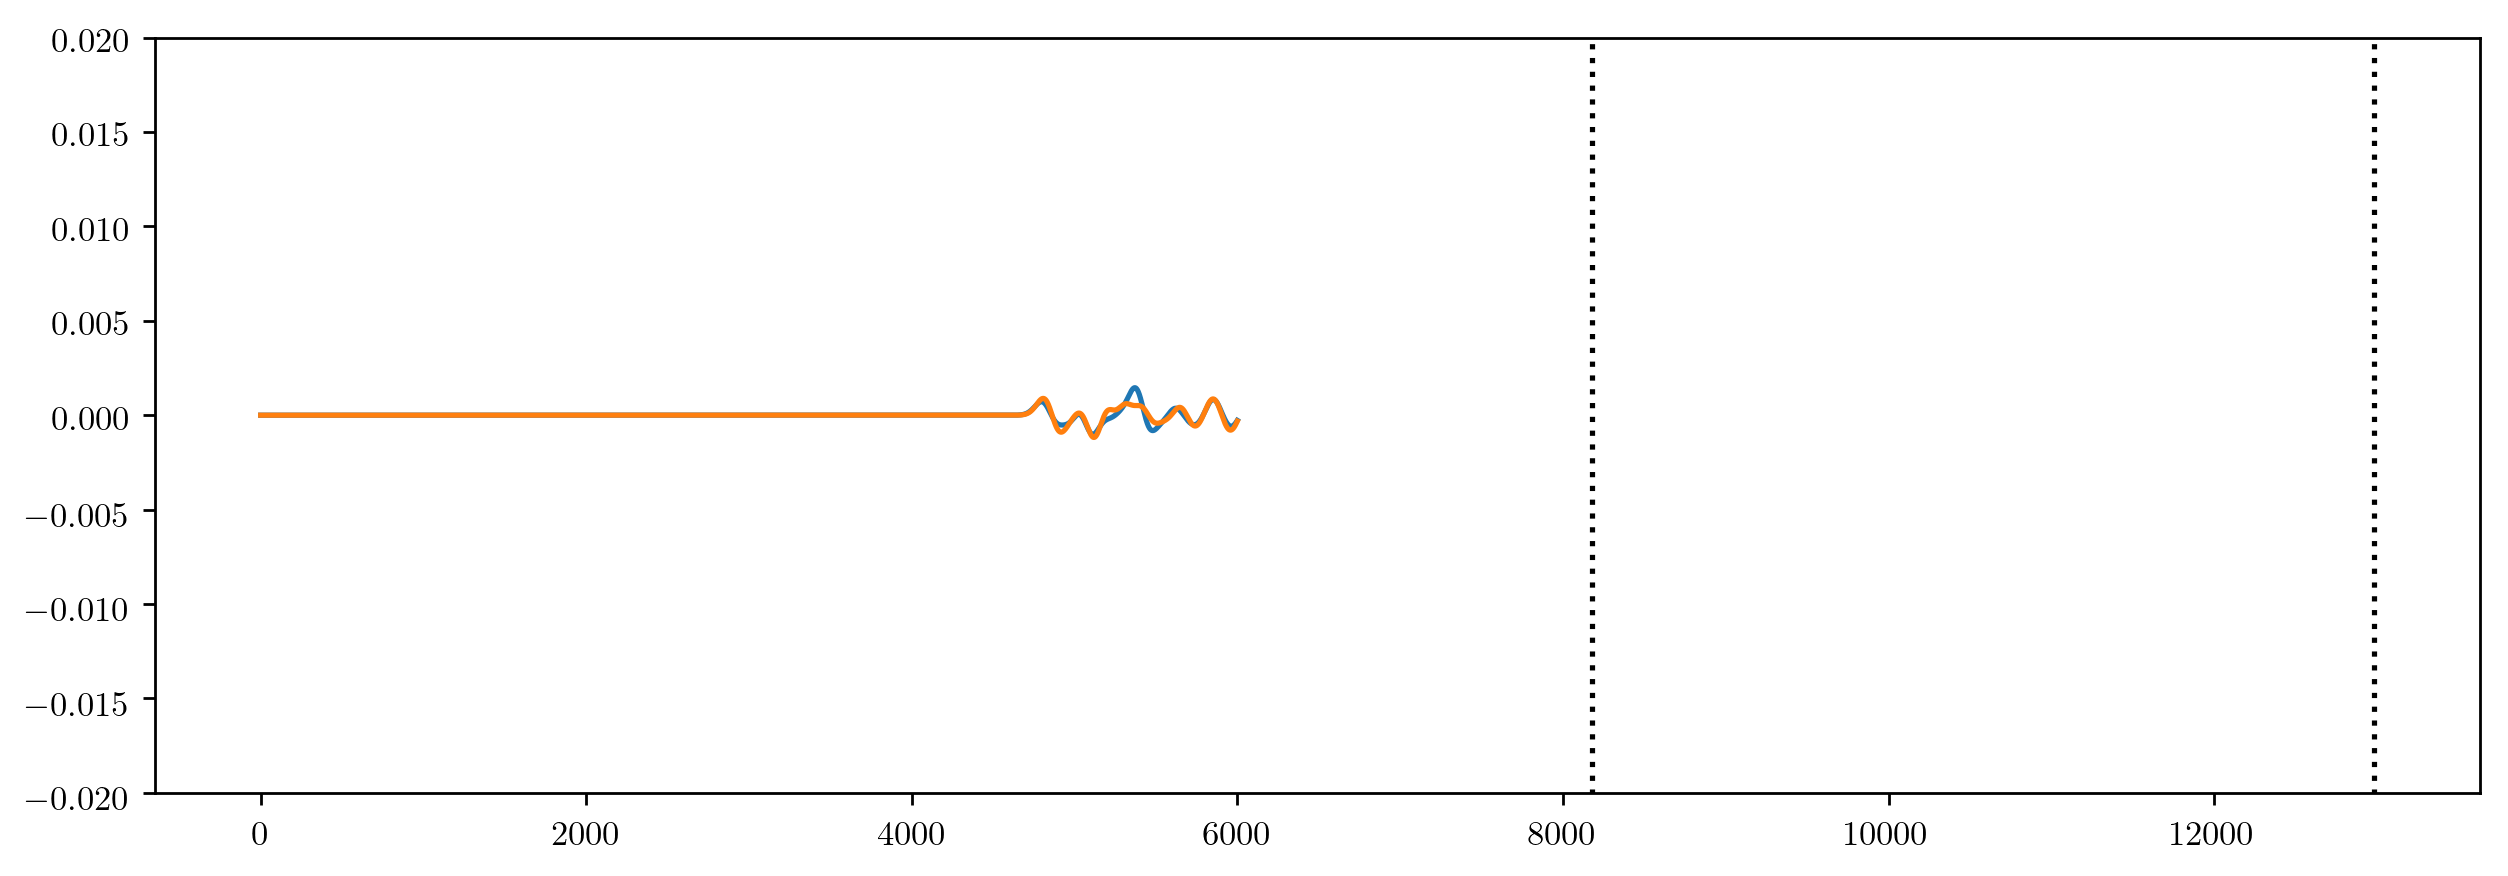

In [124]:
NTR = 250

t1 = 0.01 + 0.00044444*(adj[NTR].stats.distance-adj[NTR].stats.su.trace_header.source_coordinate_x)
nt1 = np.floor(t1/adj[NTR].stats.delta)
t2 = 0.01 + 0.00070588*(adj[NTR].stats.distance-adj[NTR].stats.su.trace_header.source_coordinate_x)
nt2 = np.floor(t2/adj[NTR].stats.delta)

plt.figure(figsize=(12,4), dpi = 250)
plt.plot(obs[NTR].data)
plt.plot(syn[NTR].data)
plt.ylim([-0.020, 0.020])
plt.plot(nt1*np.ones([10,1]), np.linspace(-0.2, 0.2, 10), ':', c = 'k')
plt.plot(nt2*np.ones([10,1]), np.linspace(-0.2, 0.2, 10), ':', c = 'k')

In [51]:
st = obspy.read('/Users/niyiyu/fsdownload/0_vz_SU')

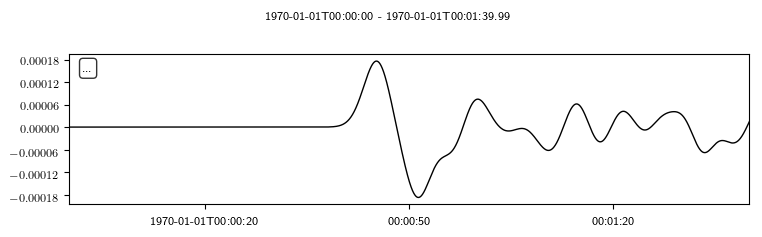

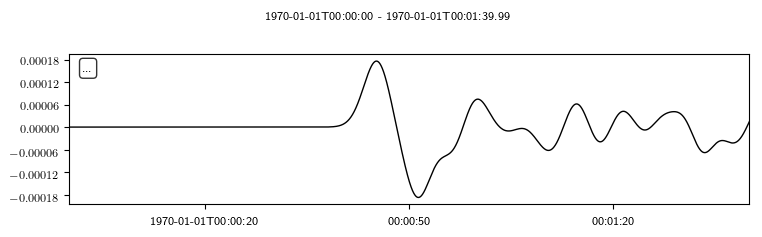

In [52]:
st[-1].plot()